## Importeer benodigde bibliotheken

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

## Laad de geveltekening in

In [ ]:
## half_vrijstaand_type_e
pad_naar_afbeelding = os.path.join("..", "Data_nest_uitgesneden", "half_vrijstaand_type_e (1).png")
img = cv2.imread(pad_naar_afbeelding)


## Toon de originele geveltekening

We converteren het beeld van BGR (OpenCV-standaard) naar RGB voor correcte weergave in Matplotlib.

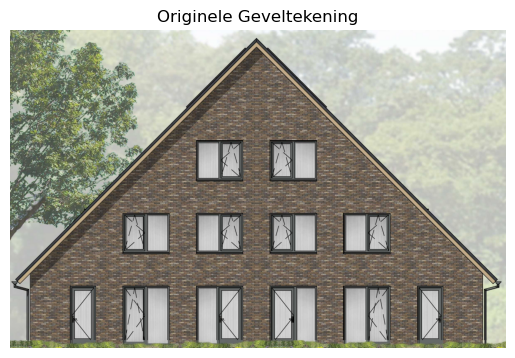

In [3]:
# Converteer van BGR (OpenCV) naar RGB (Matplotlib)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Toon de afbeelding zonder assen
plt.imshow(img_rgb)
plt.title("Originele Geveltekening")
plt.axis('off')
plt.show()

In [4]:
import os

print(os.path.exists(r"Nest-Project\Data_nest_uitgesneden\half_vrijstaand_type_e (1).png"))


False


## Zet afbeelding om naar grijswaarden

Voor veel beeldverwerkingstaken zoals randdetectie is kleurinformatie niet nodig. 
Door de afbeelding om te zetten naar grijswaarden:

- Verminderen we de hoeveelheid gegevens (van 3 kanalen naar 1).
- Worden randen en vormen duidelijker.
- Gaat de verwerking sneller en efficiënter.

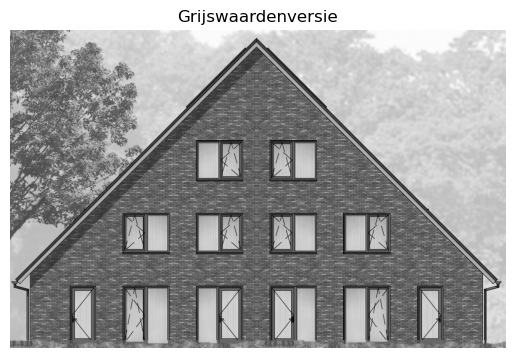

In [5]:
# Converteer afbeelding naar grijswaarden
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Toon de grijswaardenafbeelding
plt.imshow(img_gray, cmap='gray')
plt.title("Grijswaardenversie")
plt.axis('off')
plt.show()

## Gaussian Blur toepassen om ruis te verminderen

We gebruiken een Gaussian Blur om het beeld te vervagen en kleine ruis of details te onderdrukken. 
Dit zorgt ervoor dat de randdetectie robuuster en minder gevoelig is voor kleine afwijkingen.

De gekozen parameters voor de kernelgrootte `(13, 13)` en standaarddeviatie `2` zijn bepaald op basis van visuele inspectie. 
Er is geen automatische methode toegepast; we hebben geëvalueerd wat subjectief het beste resultaat geeft.

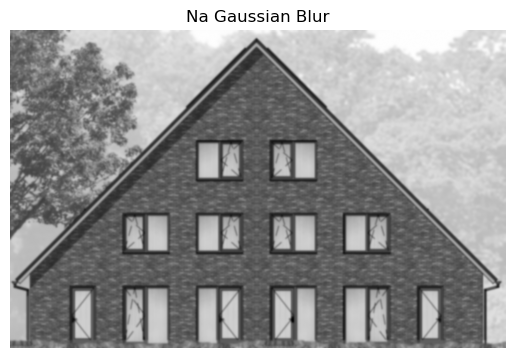

In [6]:
# Pas Gaussian Blur toe om ruis te onderdrukken
# De waarden (13, 13) en sigma 2 zijn gekozen op basis van visuele beoordeling.
# Ze gaven de meest consistente resultaten voor randdetectie in dit type afbeelding.
blur = cv2.GaussianBlur(img_gray, (13, 13), 2)

# Toon het vervaagde beeld
plt.imshow(blur, cmap='gray')
plt.title("Na Gaussian Blur")
plt.axis('off')
plt.show()

## Voer Canny-randdetectie uit

We gebruiken het Canny-algoritme om randen te detecteren in het vervaagde beeld. Canny werkt in meerdere stappen:

- Het berekent de gradiënten (sterke helderheidsveranderingen) in het beeld.
- Alleen overgangen die binnen twee drempelwaarden vallen, worden als randen herkend.
- Dankzij deze aanpak is Canny effectief in het vinden van echte randen en relatief ongevoelig voor ruis — vooral na het toepassen van een Gaussian Blur.

De gebruikte drempelwaarden `(50, 150)` zijn gekozen op basis van visuele inspectie. Er is geen automatische optimalisatie toegepast; we hebben geëvalueerd wat subjectief het meest betrouwbare resultaat geeft voor dit type afbeelding.


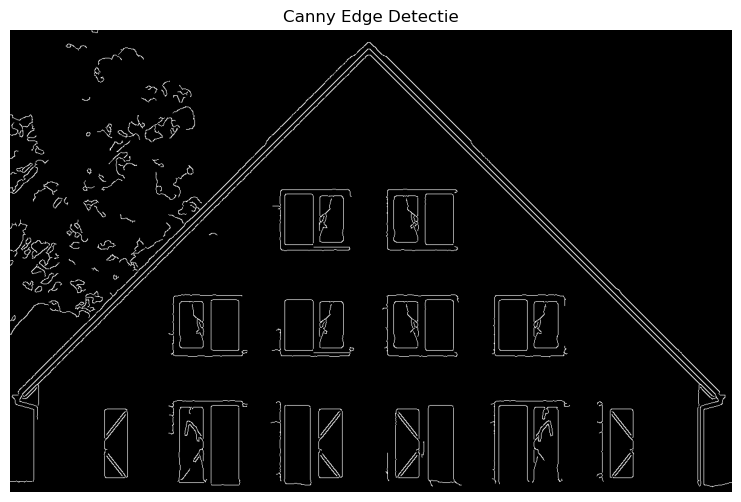

In [7]:
# Pas Canny edge detectie toe op het vervaagde beeld
# Thresholds 50 en 150 bepalen welke gradiënten als randen worden beschouwd
edges = cv2.Canny(blur, threshold1=50, threshold2=150)

# Toon het resultaat van de randdetectie
plt.figure(figsize=(10, 6))
plt.imshow(edges, cmap='gray')
plt.title("Canny Edge Detectie")
plt.axis('off')
plt.show()


## Contourdetectie en objectclassificatie

We detecteren contouren in het binaire randbeeld en classificeren deze op basis van oppervlakte:

- De grootste contour wordt beschouwd als het ‘Huis’.
- Contouren binnen bepaalde oppervlaktegrenzen worden gelabeld als ‘Deur’ of ‘Raam’.
- Elk gedetecteerd object wordt visueel gemarkeerd met een rechthoek en een tekstlabel.

Deze aanpak werkt op basis van heuristieken met drempelwaarden. De gekozen waarden zijn bepaald door visuele inspectie van de foto's, waarbij de beste waardes zijn geselecteerd.


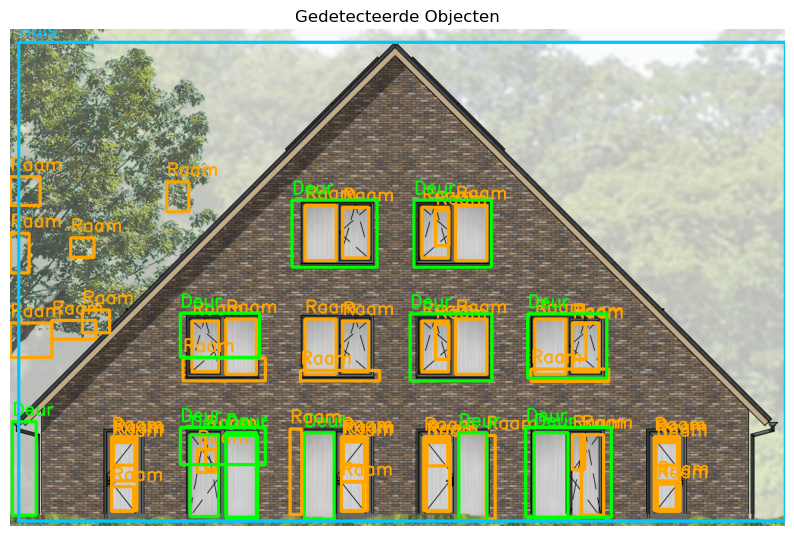

In [8]:
# Vind contouren in het binaire randbeeld
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Maak een kopie van de originele RGB-afbeelding om labels op te tekenen
output_img = img_rgb.copy()

# Bepaal de grootste contour op basis van oppervlakte
largest_cnt = max(contours, key=lambda c: cv2.boundingRect(c)[2] * cv2.boundingRect(c)[3])

# Definieer oppervlaktegrenzen voor deur en raam (in pixels)
min_area_deur = 5000
max_area_deur = 20000
min_area_raam = 1000
max_area_raam = 5000

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    area = w * h
    aspect_ratio = w / h if h != 0 else 0

    # Classificeer contour op basis van oppervlakte
    if cnt is largest_cnt:
        label = "Huis"
        color = (0, 200, 255)  # blauw
    elif min_area_deur < area < max_area_deur:
        label = "Deur"
        color = (0, 255, 0)  # groen
    elif min_area_raam < area < max_area_raam:
        label = "Raam"
        color = (255, 165, 0)  # oranje
    else:
        continue  # negeer contouren die niet binnen de criteria vallen

    # Teken rechthoek en label
    cv2.rectangle(output_img, (x, y), (x + w, y + h), color, 3)
    cv2.putText(output_img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# Toon het resultaat
plt.figure(figsize=(10, 10))
plt.imshow(output_img)
plt.title("Gedetecteerde Objecten")
plt.axis('off')
plt.show()

## Conclusie bij de contourdetectie en objectclassificatie

Deze code detecteert contouren in een afbeelding met behulp van Canny edge-detectie en `cv2.findContours`.

De aanpak is als volgt:

- De grootste contour wordt gelabeld als **"Huis"**, op basis van de grootste oppervlakte van de bounding box.
- Contouren met een oppervlakte binnen bepaalde drempels worden geclassificeerd als **"Deur"** of **"Raam"**.
- Contouren buiten deze drempelwaarden worden genegeerd.
- De contouren worden visueel weergegeven met rechthoeken en labels.

**Waarom ontstaan zowel juiste als onjuiste objecten?**

- De classificatie is uitsluitend gebaseerd op oppervlakte, waardoor objecten met vergelijkbare afmetingen (zoals delen van bomen) foutief worden gelabeld.
- Er wordt geen rekening gehouden met vorm, textuur, kleur of positie, wat leidt tot dubbele detecties en verkeerde labels.
- Overlapping tussen deur- en raamdetecties kan ontstaan doordat meerdere contouren dicht bij elkaar vallen binnen de drempelwaarden.

**Kortom:**

De huidige heuristiek werkt voor duidelijk gescheiden objecten, maar is gevoelig voor ruis en fouten bij complexe of overlappende structuren. Ter verbetering voegen we een filter toe op basis van de aspect ratio, wat de onderscheidbaarheid tussen deuren en ramen kan vergroten.

## Contourdetectie en objectclassificatie

In deze stap detecteren we contouren in het binaire randbeeld en classificeren we deze op basis van oppervlakte en aspect ratio:

- De grootste contour wordt beschouwd als het **Huis**.
- Contouren binnen bepaalde oppervlaktegrenzen én met een geschikte **aspect ratio** worden gelabeld als **Deur** of **Raam**.
- Elk gedetecteerd object wordt visueel gemarkeerd met een rechthoek en een tekstlabel.

De aanpak maakt gebruik van eenvoudige heuristieken op basis van grootte en vormverhouding. Deze drempelwaarden zijn handmatig bepaald door visuele inspectie van de dataset. Hoewel dit in veel gevallen werkt, kent het beperkingen bij overlappende structuren of achtergrondruis.


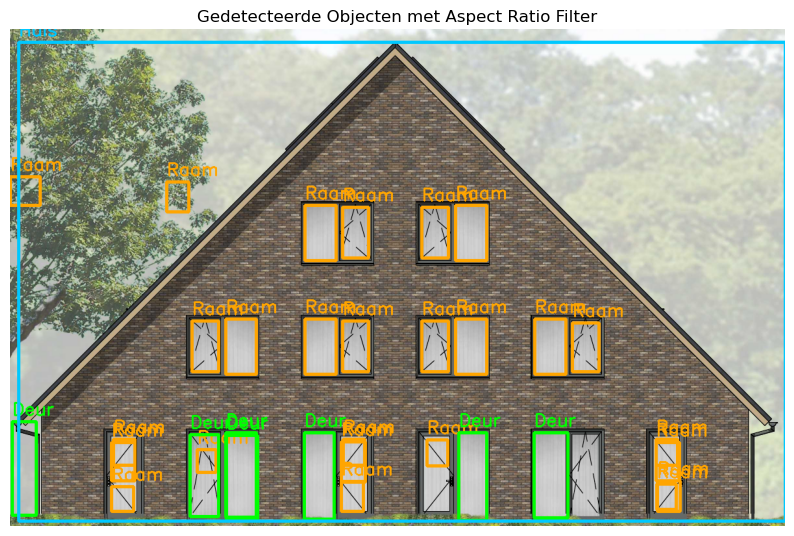

In [9]:
# Vind contouren in het randbeeld
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Kopie van de originele RGB-afbeelding om labels te tekenen
output_img = img_rgb.copy()

# Controleer of er contouren zijn gevonden
if contours:
    # Bepaal de grootste contour (huis)
    largest_cnt = max(contours, key=lambda c: cv2.boundingRect(c)[2] * cv2.boundingRect(c)[3])

    # Drempelwaarden voor oppervlakte (in pixels)
    min_area_deur = 5000
    max_area_deur = 20000
    min_area_raam = 1000
    max_area_raam = 5000

    # Aspect ratio grenzen (breedte / hoogte)
    # Voorbeeldwaarden, kunnen worden aangepast
    deur_aspect_min, deur_aspect_max = 0.1, 0.7   # deuren zijn vaak smal en hoog
    raam_aspect_min, raam_aspect_max = 0.5, 1.2  # ramen zijn vaak vierkant of iets breder

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        aspect_ratio = w / h if h != 0 else 0

        # Classificatie op basis van oppervlakte en aspect ratio
        if cnt is largest_cnt:
            label = "Huis"
            color = (0, 200, 255)  # blauw
        elif min_area_deur < area < max_area_deur and deur_aspect_min < aspect_ratio < deur_aspect_max:
            label = "Deur"
            color = (0, 255, 0)  # groen
        elif min_area_raam < area < max_area_raam and raam_aspect_min < aspect_ratio < raam_aspect_max:
            label = "Raam"
            color = (255, 165, 0)  # oranje
        else:
            continue  # negeer contouren die niet aan de criteria voldoen

        # Teken bounding box en label op de afbeelding
        cv2.rectangle(output_img, (x, y), (x + w, y + h), color, 3)
        cv2.putText(output_img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# Toon het resultaat
plt.figure(figsize=(10, 10))
plt.imshow(output_img)
plt.title("Gedetecteerde Objecten met Aspect Ratio Filter")
plt.axis('off')
plt.show()

## Conclusie na toevoegen van aspect ratio filter

Door naast oppervlakte ook het **aspect ratio** (breedte/hoogte) te gebruiken, verbetert de classificatie van objecten zoals ramen en deuren aanzienlijk. Deze extra filter helpt om objecten met een vergelijkbare grootte maar een afwijkende vorm — zoals delen van bomen — beter uit te sluiten.

Toch blijft de aanpak beperkt en kunnen er nog steeds fouten optreden, omdat:

- De classificatie nog steeds uitsluitend op simpele heuristieken gebaseerd is (oppervlakte en aspect ratio).
- Complexe vormen, overlappende objecten of onregelmatige contouren moeilijk correct worden geclassificeerd met alleen deze parameters.

Kortom, deze verbeterde heuristiek is een stap vooruit, maar voor een robuustere en nauwkeurigere detectie is het model niet genoeg voldoedne hij mist deuren en geeft op deruen soms dubbel ramen 


## Korte lijnen detecteren en verwijderen uit edge afbeelding
We gebruiken de probabilistische Hough-transformatie om lijnen in het Canny edge beeld te detecteren. Vervolgens verwijderen we korte lijnen die korter zijn dan een vooraf ingestelde drempel, omdat deze meestal ruis of onbelangrijke details vertegenwoordigen. Dit helpt om de contourdetectie nauwkeuriger te maken.

### Bekijk eerst de edge-afbeelding

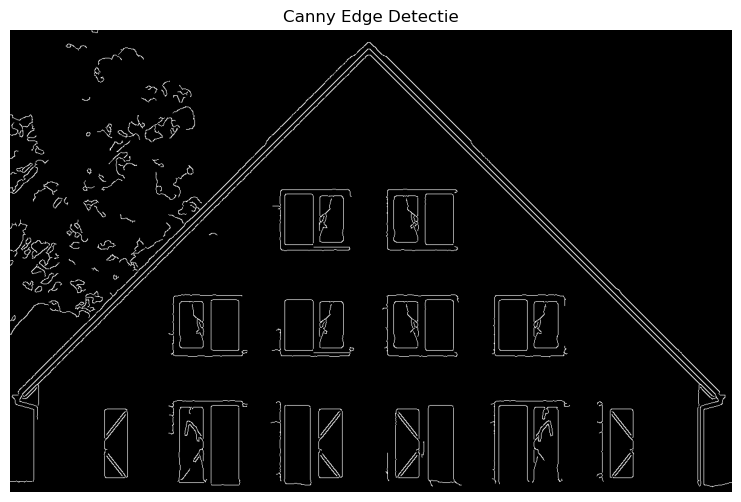

In [10]:
# Toon het resultaat
plt.figure(figsize=(10, 6))
plt.imshow(edges, cmap='gray')
plt.title("Canny Edge Detectie")
plt.axis('off')
plt.show()

### Verwijder de korte lijnen

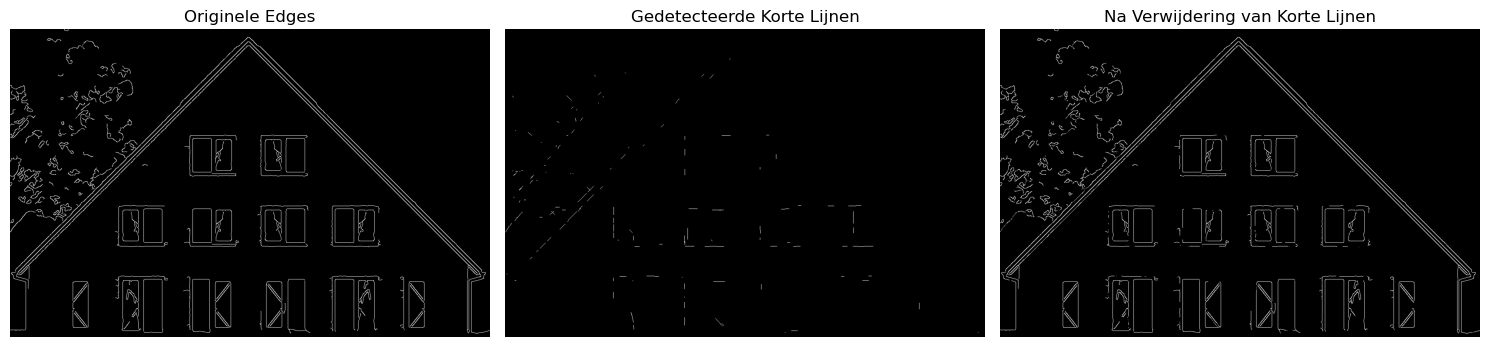

In [11]:
# Parameters voor korte lijn detectie
min_line_length = 30  # Lijnen korter dan dit worden verwijderd
max_line_gap = 2     # Maximale gap tussen lijnsegmenten om samengevoegd te worden

# Detecteer lijnen met probabilistische Hough-transformatie
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=50,
                        minLineLength=1, maxLineGap=max_line_gap)

# Maak lege afbeeldingen voor korte lijnen en gefilterde edges
short_lines_img = np.zeros_like(edges)
filtered_edges = edges.copy()

# Verwijder korte lijnen uit de edge afbeelding
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        if length < min_line_length:
            # Markeer korte lijnen in aparte afbeelding
            cv2.line(short_lines_img, (x1, y1), (x2, y2), 255, 1)
            # Verwijder korte lijnen uit de originele edges
            cv2.line(filtered_edges, (x1, y1), (x2, y2), 0, 1)

# Visualiseer originele edges, korte lijnen en gefilterde edges
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(edges, cmap='gray')
plt.title("Originele Edges")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(short_lines_img, cmap='gray')
plt.title("Gedetecteerde Korte Lijnen")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(filtered_edges, cmap='gray')
plt.title("Na Verwijdering van Korte Lijnen")
plt.axis('off')

plt.tight_layout()
plt.show()

## Conclusie
We hebben de parameters van de Hough-transformatie aangepast en getest op meerdere verschillende foto's. De best werkende waarden zijn ingesteld op:

min_line_length = 30
max_line_gap = 2

We kiezen deze instellingen omdat hogere waarden ertoe leiden dat ook belangrijke lijnen, zoals van deuren of ramen, onbedoeld worden verwijderd. Met deze drempels blijft de belangrijke structuur grotendeels behouden, terwijl de meeste korte en irrelevante lijnen succesvol verwijderd worden.

Toch zien we dat er nog steeds veel ruis aanwezig is in de afbeelding. De impact van deze stap op de algehele nauwkeurigheid van de objectdetectie blijkt beperkt te zijn.

## Contouren vinden in opgeschoonde edge-afbeelding en objecten labelen
Na het verwijderen van korte lijnen uit het edge-beeld, detecteren we opnieuw de contouren in de afbeelding. We classificeren de gedetecteerde contouren vervolgens als huis, deur of raam, op basis van twee eigenschappen:

Oppervlakte (area) van de bounding box
Aspect ratio (verhouding breedte/hoogte)

De grootste contour wordt automatisch als "Huis" beschouwd. Andere contouren worden enkel gelabeld als "Deur" of "Raam" als ze binnen vooraf bepaalde grenzen voor oppervlakte én aspect ratio vallen.

Deze extra filters helpen bij het onderdrukken van ruis en irrelevante structuren, zoals takken of schaduwen, die eerder foutief als ramen of deuren werden aangeduid.

In de volgende visualisatie zien we het resultaat van deze verbeterde detectiestap, met bounding boxes en labels voor elk herkend object.

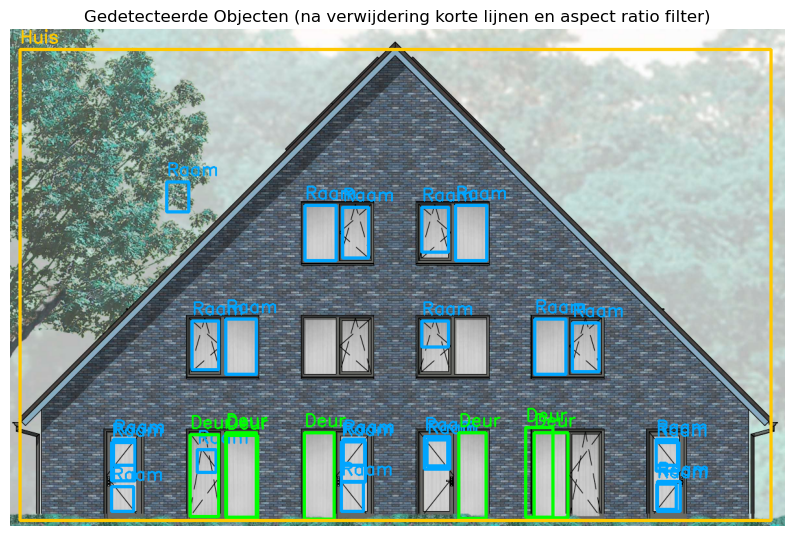

In [12]:
contours, _ = cv2.findContours(filtered_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Maak kopie van originele afbeelding in kleur
output_img = img_rgb.copy()

if contours:
    # Bepaal grootste contour → dit stellen we gelijk aan het huis
    largest_cnt = max(contours, key=lambda c: cv2.boundingRect(c)[2] * cv2.boundingRect(c)[3])
    largest_area = cv2.boundingRect(largest_cnt)[2] * cv2.boundingRect(largest_cnt)[3]

    # Drempels voor classificatie (aangepast indien nodig)
    min_area_deur = 5000
    max_area_deur = 20000
    min_area_raam = 1000
    max_area_raam = 5000

    # Aspect ratio ranges (breedte / hoogte)
    deur_aspect_min, deur_aspect_max = 0., 0.7  # deuren zijn vaak smal en hoog
    raam_aspect_min, raam_aspect_max = 0.5, 1.2  # ramen zijn vaak bijna vierkant

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        aspect_ratio = w / h if h != 0 else 0

        # Classificatie op basis van grootte en aspect ratio
        if np.array_equal(cnt, largest_cnt):
            label = "Huis"
            color = (0, 200, 255)  # blauw
        elif min_area_deur < area < max_area_deur and deur_aspect_min < aspect_ratio < deur_aspect_max:
            label = "Deur"
            color = (0, 255, 0)  # groen
        elif min_area_raam < area < max_area_raam and raam_aspect_min < aspect_ratio < raam_aspect_max:
            label = "Raam"
            color = (255, 165, 0)  # oranje
        else:
            continue  # negeer objecten die niet in de klassen passen

        # Teken bounding box en label
        cv2.rectangle(output_img, (x, y), (x + w, y + h), color, 3)
        cv2.putText(output_img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# Toon resultaat
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.title("Gedetecteerde Objecten (na verwijdering korte lijnen en aspect ratio filter)")
plt.axis('off')
plt.show()

## Conclusie
In deze stap is de nauwkeurigheid van de objectdetectie (huis, deur, raam) verbeterd door naast de oppervlakte (area) ook de aspect ratio (breedte/hoogte) toe te voegen als filtercriterium. Dit helpt typische kenmerken van deuren (hoog en smal) en ramen (meer vierkant) beter te onderscheiden.

De resultaten laten enige verbetering zien: er zijn minder foutieve detecties van willekeurige objecten. Toch blijven er duidelijke beperkingen zichtbaar:

Deuren worden niet altijd correct gedetecteerd — ze worden soms gemist of foutief als raam geclassificeerd.

Boomstructuren worden verward met ramen — dit komt door overeenkomende contourvormen en afmetingen.

Dubbele detecties — sommige objecten worden meermaals gelabeld (bijv. als zowel raam als deur).

Gevoeligheid voor ruis — zoals schaduwen, bladeren of overlappingen die contouren verstoren.

Deze problemen tonen de beperkingen aan van een klassieke (rule-based) aanpak gebaseerd op handmatige drempels en eenvoudige geometrische kenmerken.

Deze heuristische benadering is onvoldoende robuust voor complexe gevelbeelden. Voor betere prestaties is een data-gedreven methode aanbevolen, zoals machine learning of deep learning, waarbij het model leert van voorbeelden en contextueel onderscheid kan maken tussen objecten.